In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/delhi-tweets/finaldelhi-2.csv
/kaggle/input/roberta-weights/model.h5


In [2]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-02-14 01:51:17.473269: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-14 01:51:17.473389: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

2022-02-14 01:51:21.997993: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-14 01:51:22.000721: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-14 01:51:22.000750: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-14 01:51:22.000783: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c817a0e02b89): /proc/driver/nvidia/version does not exist
2022-02-14 01:51:22.004082: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [4]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 35
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 2

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [5]:
df = pd.read_csv('../input/delhi-tweets/finaldelhi-2.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df = df.reset_index(drop = True)
df

,id,date,content
0,1432855585377034241,2021-08-31,put recurring deposit build corpus
1,1432854840539959298,2021-08-31,रखकर कसम मगर
2,1432854075926724613,2021-08-31,लकर नफरत रगत करत आपक मदद अपन वडग मतक बदल chand...
3,1432853935748890624,2021-08-31,har har mahadev
4,1432853736360079365,2021-08-31,dear please like subscribe share friend
...,...,...,...
873919,1454962294778073092,2021-11-01,patheticdisplay wokeism indian cricket teamthe...
873920,1454961574431444994,2021-11-01,haal pure desh mein hai chahhe asha dot sac ko...
873921,1454961551874539521,2021-11-01,portrait city soldier
873922,1454961484140740610,2021-11-01,switch tennis cricket dont know write continui...


In [6]:
from datetime import datetime

def strtodate(text):
    return datetime.strptime(text, '%Y-%m-%d').date()

df['date']=df['date'].apply(strtodate)

In [7]:
df = df.sort_values(by="date")
df = df.reset_index(drop=True)
df

,id,date,content
0,1410687041436667905,2021-07-01,poisonous eat hungry joking
1,1410582104765652994,2021-07-01,doctor national doctor day
2,1410582053637132288,2021-07-01,पहर neeraj suryavanshi
3,1410582003095793666,2021-07-01,करन करत रहत bachchan bollywood
4,1410581967129563142,2021-07-01,thank much showering love song keep supporting...
...,...,...,...
873919,1476833184192991234,2021-12-31,expecting anything new year hoping great year ...
873920,1476833014814367747,2021-12-31,morning glow afternoon
873921,1476832870832361473,2021-12-31,यनव नवल सरलज पकड नतम अठख गरल
873922,1476833539790307329,2021-12-31,garib maharaj also told nectar speech prison d...


In [8]:
X_data = df[['content']].to_numpy().reshape(-1)

In [9]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [10]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [11]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [12]:
with strategy.scope():
    model = build_model(2)
    model.summary()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [13]:
model.load_weights('../input/roberta-weights/model.h5')

In [14]:
X_train = roberta_encode(X_data, tokenizer)

In [15]:
predictions = model.predict(X_train)
print(predictions)

[[9.9081194e-01 9.1881277e-03]
 [5.8083862e-01 4.1916135e-01]
 [1.2117713e-01 8.7882292e-01]
 ...
 [3.6874582e-08 1.0000000e+00]
 [1.2863085e-04 9.9987137e-01]
 [6.1245501e-01 3.8754502e-01]]


In [16]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[0 0 1 ... 1 1 0]


In [17]:
df['label']=classes
df

,id,date,content,label
0,1410687041436667905,2021-07-01,poisonous eat hungry joking,0
1,1410582104765652994,2021-07-01,doctor national doctor day,0
2,1410582053637132288,2021-07-01,पहर neeraj suryavanshi,1
3,1410582003095793666,2021-07-01,करन करत रहत bachchan bollywood,1
4,1410581967129563142,2021-07-01,thank much showering love song keep supporting...,1
...,...,...,...,...
873919,1476833184192991234,2021-12-31,expecting anything new year hoping great year ...,1
873920,1476833014814367747,2021-12-31,morning glow afternoon,0
873921,1476832870832361473,2021-12-31,यनव नवल सरलज पकड नतम अठख गरल,1
873922,1476833539790307329,2021-12-31,garib maharaj also told nectar speech prison d...,1


In [18]:
df.to_csv('Delhi_updated.csv')

In [19]:
df['label'].value_counts()

1    522219
0    351705
Name: label, dtype: int64

In [20]:
x = df.groupby('date') \
       .agg({'content':'size', 'label':'mean'}) \
       .rename(columns={'content':'count','label':'PCI'}) \
       .reset_index()
print (x)

           date  count       PCI
0    2021-07-01   4968  0.655193
1    2021-07-02   5253  0.607462
2    2021-07-03   4759  0.596554
3    2021-07-04   4666  0.614231
4    2021-07-05   4853  0.611374
..          ...    ...       ...
179  2021-12-27   4480  0.558482
180  2021-12-28   5071  0.570696
181  2021-12-29   4399  0.562173
182  2021-12-30   4682  0.574754
183  2021-12-31   5484  0.589533

[184 rows x 3 columns]


In [21]:
x.to_csv('Delhi_PCI.csv')

<AxesSubplot:xlabel='date'>

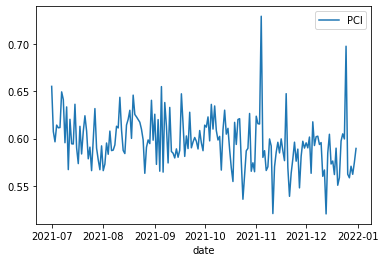

In [22]:
x.plot(x="date", y=["PCI"])